# <center>Interactive visualization of climate model data via Python or GUI with psyplot</center>

<div>
    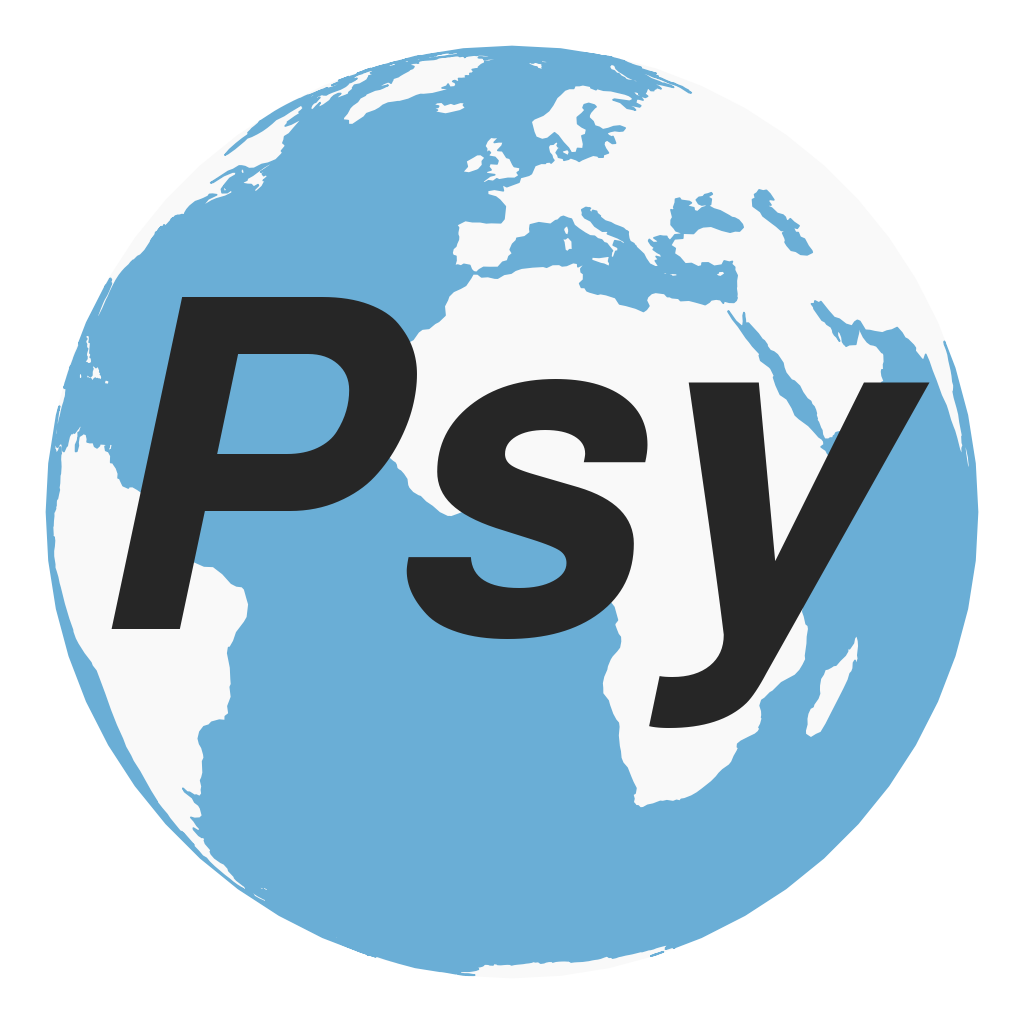
</div>

## DACH 2022

Philipp S. Sommer

Helmholtz-Zentrum Hereon,
Helmholtz Coastal Data Center

March 23rd, 2022

[Help](#/2/0)

## Technical Note <a id='help'></a>

This presentation is a jupyter notebook presented with [rise][rise] for interactive execution of the cells.
You can run it interactively on mybinder in your browser: 

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/Chilipp/psyplot-DACH2022-presentation/main?filepath=psyplot-framework-presentation.ipynb)

The link to the repo on Github: https://github.com/Chilipp/psyplot-DACH2022-presentation).

[Back to first slide](#/0/0)

[rise]: https://rise.readthedocs.io

So let's import some libraries for the execution

In [ ]:
%matplotlib widget

import psyplot.project as psy

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from IPython.display import display, Video

from ipympl.backend_nbagg import Canvas
Canvas.header_visible.default_value = False

import warnings
warnings.filterwarnings("ignore", r"\s*The on_mappable_changed")
warnings.filterwarnings("ignore", r"\s*The input coordinates")
warnings.filterwarnings("ignore", r"\s*shading=")
warnings.filterwarnings("ignore", r"\s*\[Warning by")

## Outline

#### Main features of psyplot

#### How to use and extend the framework

#### Some more features of psyplot

### Note:

I am not a visualization expert

The aim of this talk is not to show wonderful plots, but rather how to generate them. 

You can always make them publication-ready using the rich features of matplotlib.

<h2 class="section-heading">Main features of psyplot</h2>

## Using psyplot from Python

In [ ]:
ds = psy.open_dataset("data/icon_grid_demo.nc")
ds

In [ ]:
sp = ds.psy.plot.mapplot(
    name="t2m",
)

## Working interactively from the command line

In [ ]:
sp = ds.psy.plot.mapplot(
    name="t2m", cmap="Blues",
)

In [ ]:
sp.update(cmap="Reds")

In [ ]:
sp.update(title="%(time)s")

In [ ]:
sp.update(time=3)

In [ ]:
sp.update(lonlatbox="Europe")

In [ ]:
psy.close("all")

## Using the GUI

psyplot comes with a flexible graphical user interface (GUI).

- On mybinder: click [here](../desktop).
- On mistral:
  
  - either via X11
      ```bash
      ssh -X mistral
      module load python3
      psyplot
      ```
  - or [via remote desktop][remote-mistral]
- On your on own working station: Install it via `conda install -c conda-forge psy-view`

  
  
[remote-mistral]: https://www.dkrz.de/up/services/analysis/visualization/visualization-on-mistral

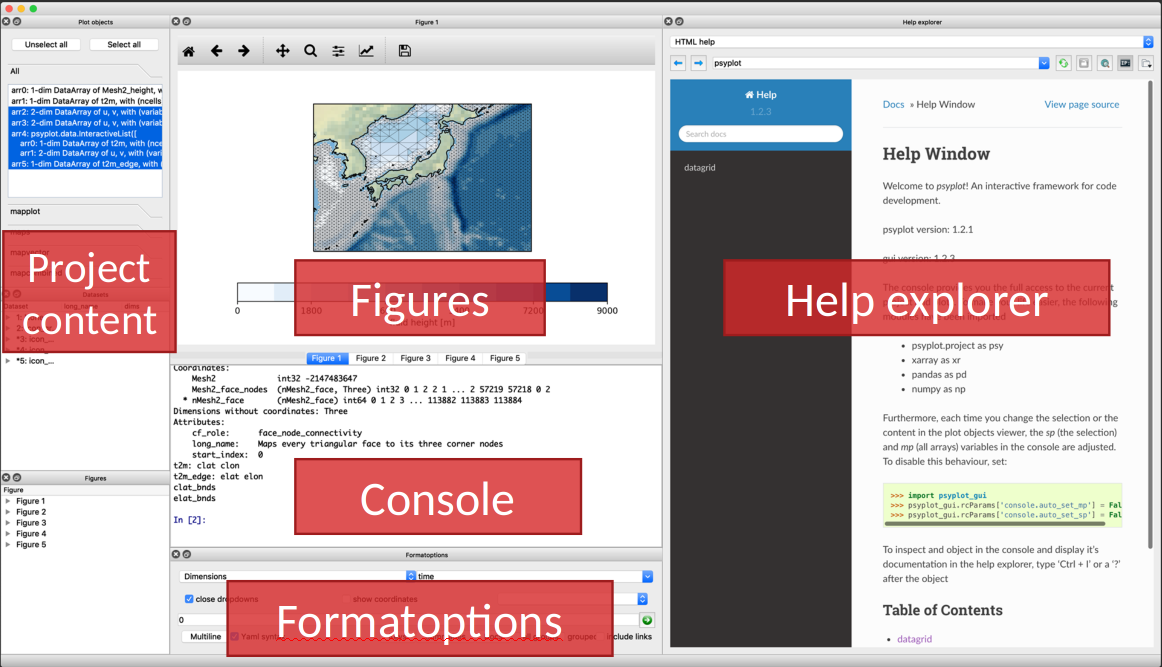

## psy-view

### An ncview-like interface, but with psyplot

- quick access to netcdf-variables via buttons
- switch between projections
- modify basemap
- change labels, colormaps, etc.
- display time-series when clicking on the map
- load presets for your plots
- animate through time, z, etc.

https://psyplot.github.io/psy-view

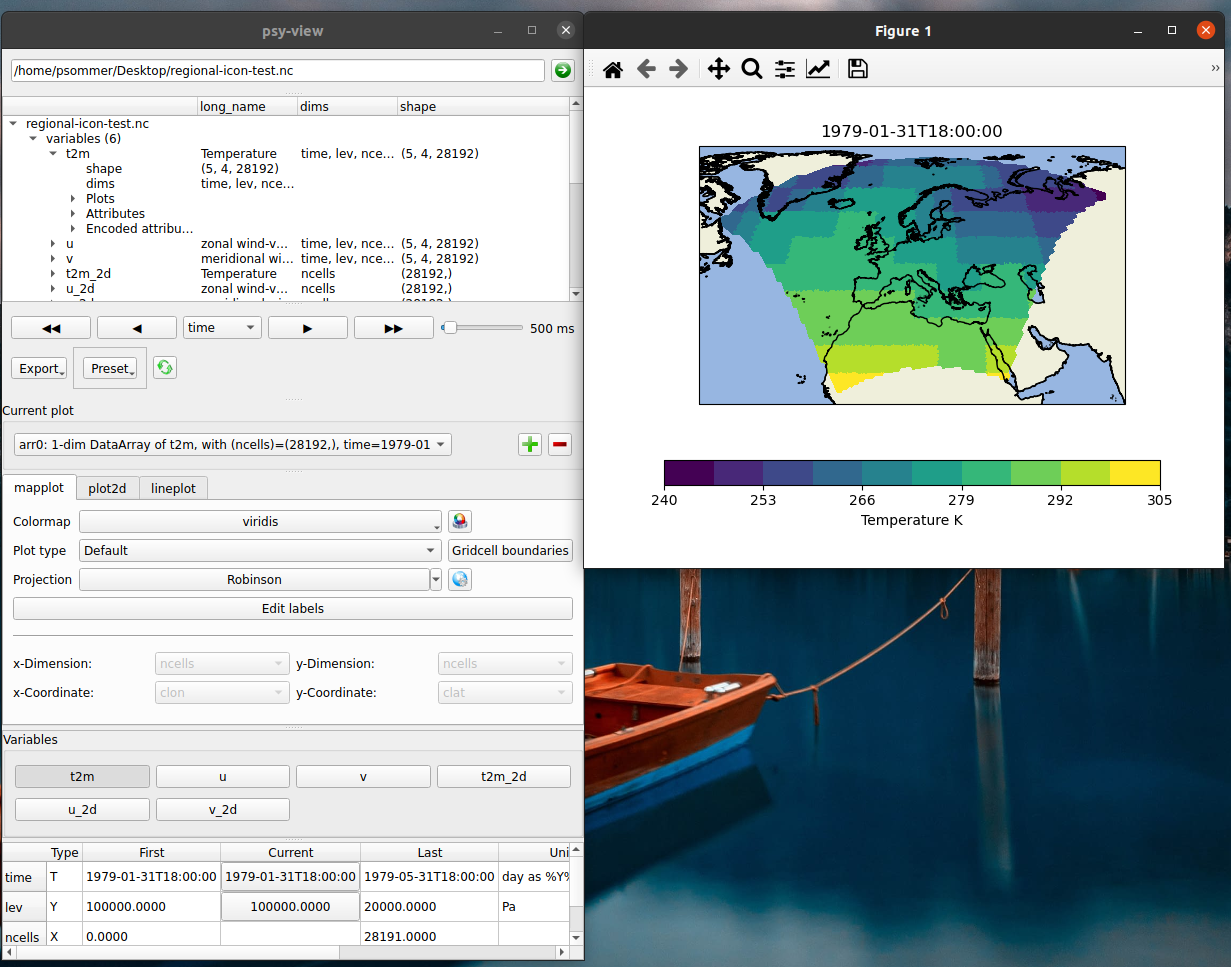

## The psyplot GUI

### Flexible GUI for coding and clicking

- integrated IPython console for interactive use of the command line
- connected help window that renders help and python object documentation
- integrated psy-view window
- shortcut widgets for individual formatoptions

https://psyplot.github.io/psyplot-gui

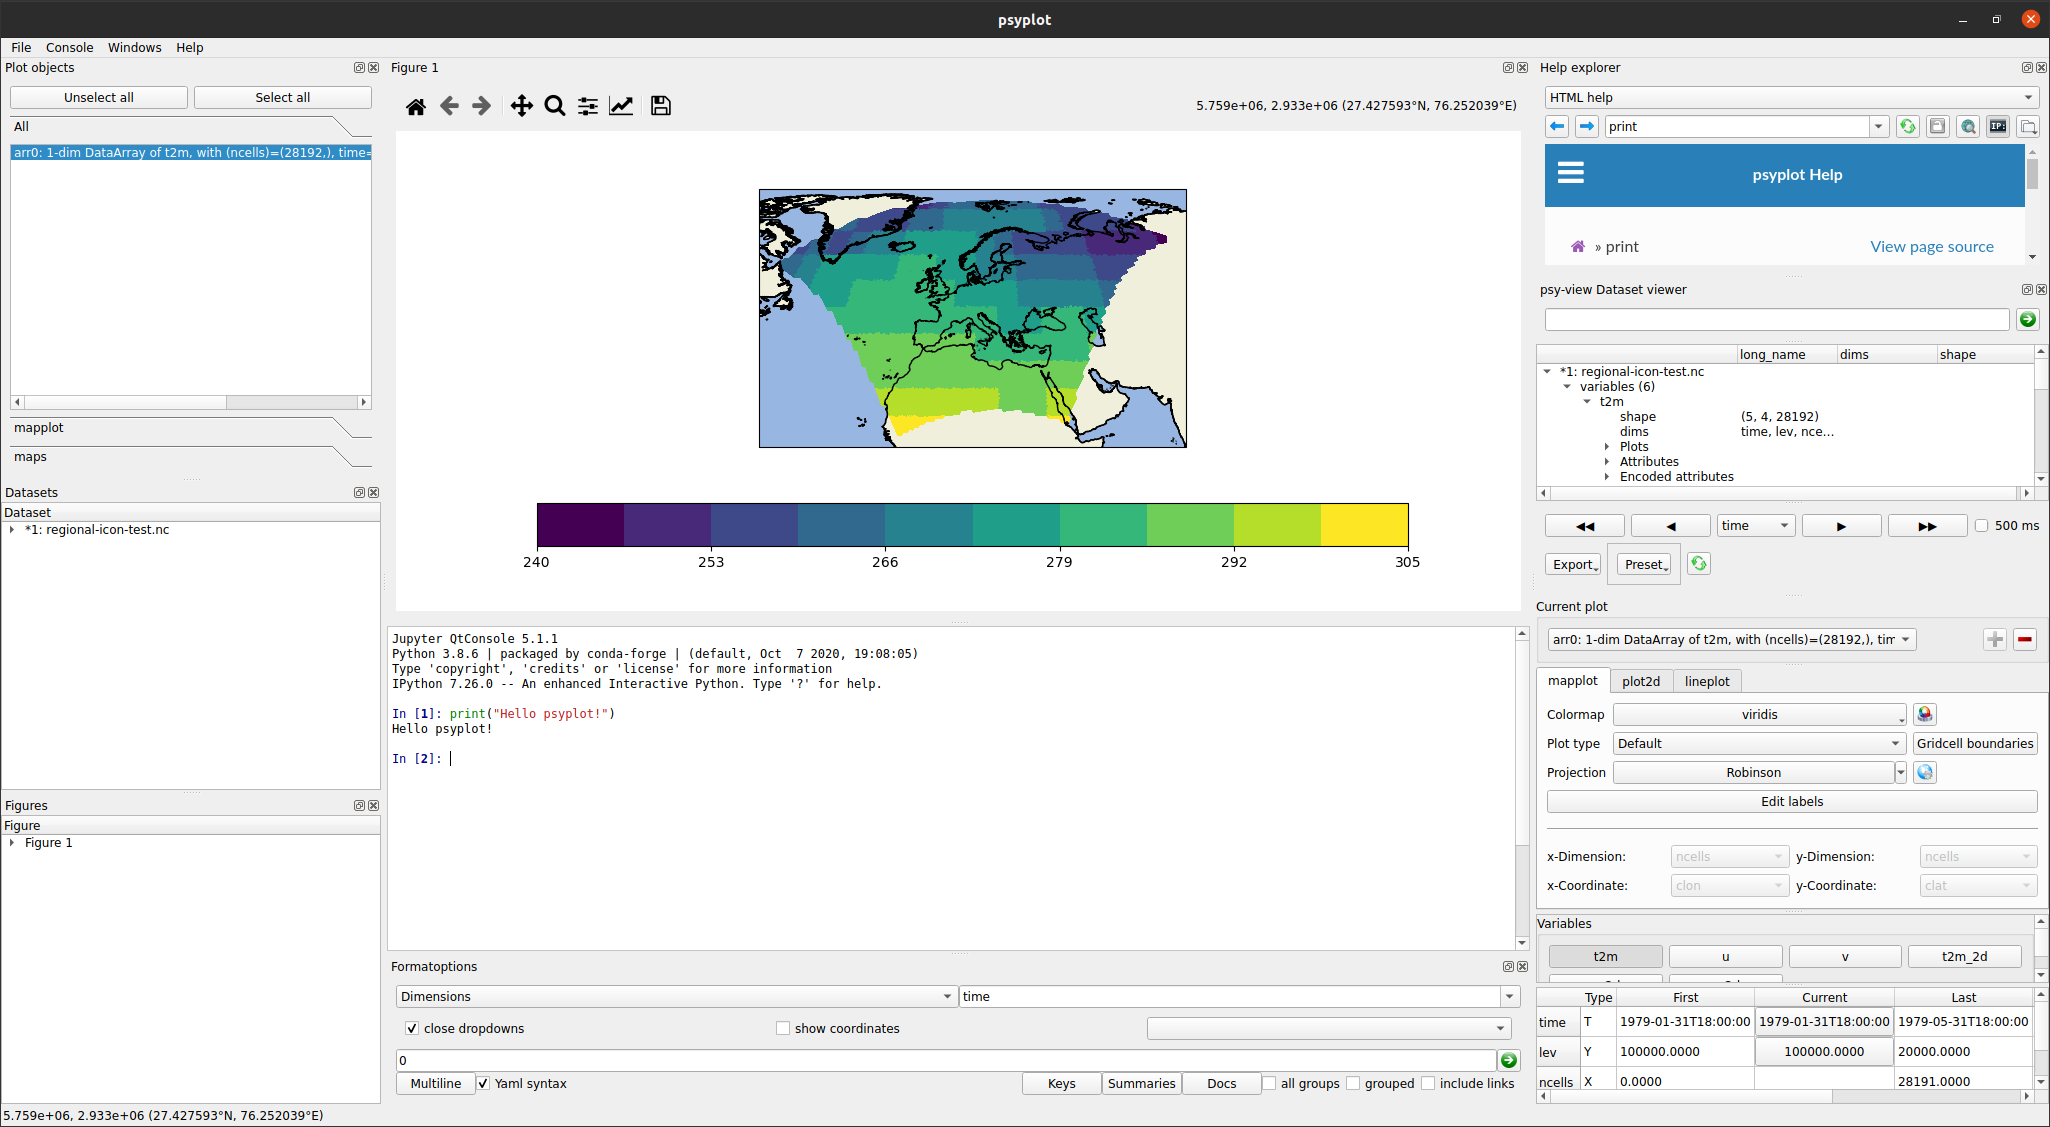

<h2 class="section-heading">An introduction into the psyplot framework</h2>

## The psyplot data model

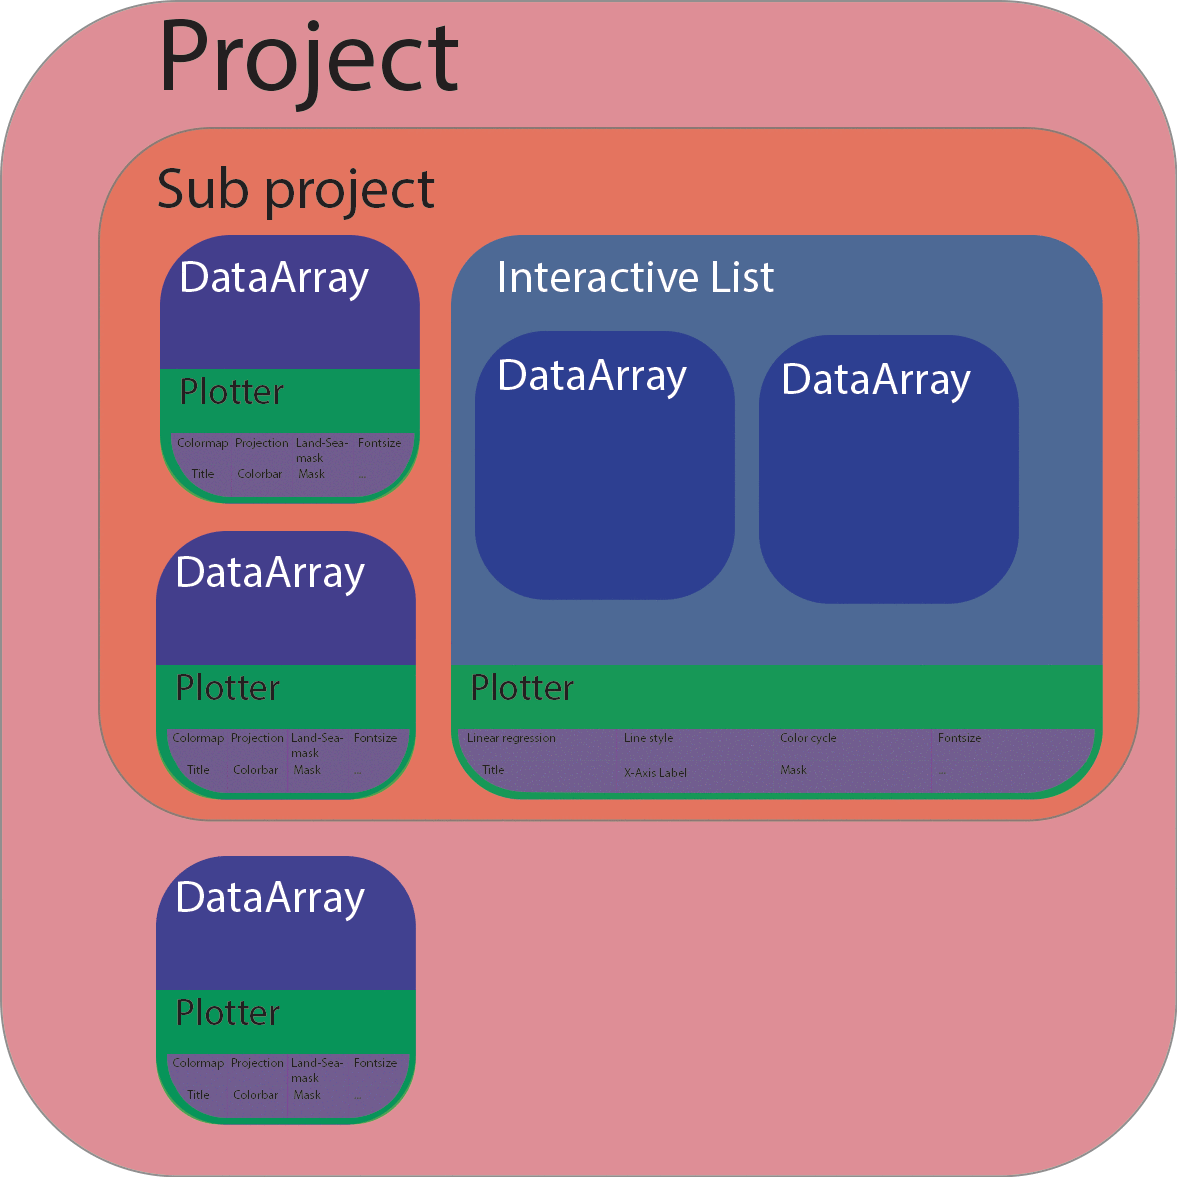

- `Formatoption`: The smallest possible unit. Each formatoption controls one aspect of the plot (cmap, lonlatbox, etc.)
- `Plotter`: A set of formatoptions that visualizes data

- `DataArray`: Standard `xarray`
- `InteractiveList`: A collection of `DataArray`s that are visualized by one plotter (e.g. a collection of lines)

- `Project`: A set of data objects, each visualized by one plotter
- `Sub project`: A subset of a larger `Project`

## Low-level interface

#### import the necessary objects from the framework

In [ ]:
from psyplot.plotter import Formatoption, Plotter

#### define a formatoption

In [ ]:
class MyFormatoption(Formatoption):
    
    #: the default value for the formatoption
    default = 'my text'
    
    def initialize_plot(self, value):
        # method initialize the plot in the very beginning
        self.text = self.ax.text(0.5, 0.5, value, fontsize="xx-large")
        
    def update(self, value):
        # method to update the plot
        self.text.set_text(value)

#### assign the formatoption to a plotter

In [ ]:
class MyPlotter(Plotter):
    my_fmt = MyFormatoption('my_fmt')

## Low-level interface

In [ ]:
# make the plot

ds = psy.open_dataset('data/demo.nc')

data = ds.psy.t2m

plotter = MyPlotter(data)

In [ ]:
# turn it into a project

from psyplot.project import Project
project = Project([data])

project

In [ ]:
# update the plot

data.psy.update(my_fmt="via the data accessor")

In [ ]:
plotter.update(my_fmt="via the plotter")

In [ ]:
project.update(my_fmt="via the project")

In [ ]:
# finally, you should always close the project
project.close(True, True, True)

Tutorial notebook: https://psyplot.github.io/examples/general/example_extending_psyplot.html

## High-level interface

You can register plotters such that they become available via `psyplot.project.plot.<something>`, or `xarray.Dataset.psy.plot.<something>`.

In [ ]:
psy.register_plotter('my_plotter', MyPlotter.__module__, 
                     'MyPlotter', MyPlotter)

In [ ]:
psy.plot.my_plotter('data/demo.nc', name='t2m')

In [ ]:
ds.psy.plot.my_plotter(name="t2m")

## Plugins for visualization

psyplot is the core that defines the framework (Plotter, Formatoption, Project, CFDecoder), the plot methods are implemented by plugins:

- `psy-simple`: for standard 1D and 2D plot
    * e.g. lineplot, plot2d, vector, barplot
- `psy-maps`: for georeferenced plots (i.e. maps)
    * e.g. mapplot, mapvector, etc.
- `psy-reg`: for regression analysis
    * linreg, densityreg

In [ ]:
psy.plot.show_plot_methods()

## They already have a lot of formatoptions available

In [ ]:
psy.plot.mapplot.keys(grouped=True)

## Make your own data plotter

In [ ]:
import numpy as np
from psy_simple.plotters import CMap, Bounds
from psy_maps.plotters import Transform, MapPlot2D

from psyplot.plotter import Plotter

class MySimpleMapplot(Plotter):
    
    # Specify the defaults
    rc = {
        "cmap": "Reds",
        "norm": None,
        "transform": "cf",
        "plot": "poly",
    }
    
    def convert_coordinate(self, coord, *variables):
        if coord.attrs.get("units", "").startswith("radian") or any(
            var.attrs.get('units', '').startswith('radian')
            for var in variables
        ):
            coord = coord.copy(data=coord * 180. / np.pi)
            coord.attrs["units"] = "degrees"
        return coord
    
    # Specify the formatoptions
    cmap = CMap("cmap", bounds="norm")
    norm = Bounds("norm")
    transform = Transform("transform")
    
    plot = MapPlot2D("plot", bounds="norm")
    

def plot(data, ax, **formatoptions):
    return MySimpleMapplot(
        data, ax=ax, **formatoptions
    )

In [ ]:
fig, ax = plt.subplots(subplot_kw=dict(
    projection=ccrs.PlateCarree())
)
ax.set_global()

ds = psy.open_dataset("data/icon.nc")

plot(ds.psy.t2m, ax=ax);

<h2 class="section-heading">Other features of psyplot</h2>

## Save and load projects

In [ ]:
initial = psy.plot.mapplot('data/demo.nc', name='t2m', title='Initial project')
initial.save_project('my-project.pkl')

In [ ]:
reloaded = psy.Project.load_project('my-project.pkl')
reloaded.update(title='Reloaded project')

## Export plots

In [ ]:
plt.ioff()

with psy.plot.mapplot('data/demo.nc', name='t2m', time=[0, 1, 2], title='%(time)s') as sp:
    sp.export('data/step-%i.png')

plt.ion()

!ls data/step-?.png

In [ ]:
from IPython.display import display, HTML, Image
s = '<table><tr><td><img src="data/step-1.png"></td><td><img src="data/step-2.png"></td><td><img src="data/step-3.png"></td></tr></table>'
display(HTML(s))

## Generate plots from the command line

In [ ]:
!echo 'projection: robin' > fmt.yml
!psyplot data/demo.nc -n t2m -pm mapplot -fmt fmt.yml -o data/output.png

In [ ]:
display(Image('data/output.png'))

## Summary

### The framework
- the psyplot core for the data model, and plugins for various visualizations
- designed to be flexible and sustainable
- equipped via flexible graphical user interface

### The data model
- based on a netCDF-like infrastructure and interpretes CF- and UGRID conventions
- support for multiple grids: rectilinear, circumpolar and unstructured

### Scriptability
- close to the data with a minimum of visualization overhead (compared to Paraview or something else)
- can easily be enhanced by other powerful libraries, such as scipy, scikit-learn, etc.